# Multi-dimensional binning.

In [32]:
%matplotlib inline

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

import matplotlib
from tqdm import trange

import astropy.stats as aps

import aviary as av

plotpar = {'axes.labelsize': 30,
           'font.size': 30,
           'legend.fontsize': 15,
           'xtick.labelsize': 30,
           'ytick.labelsize': 30,
           'text.usetex': True}
plt.rcParams.update(plotpar)

In [33]:
df = pd.read_csv("../all_rvs.csv")
print(len(df.all_vz), len(df.all_vz.values[np.isfinite(df.all_vz.values)]))
# flag_mask = df.flag.values == 1
# df = df.iloc[flag_mask]
# print(np.shape(df))

35328 35328


/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3063: DtypeWarning: Columns (5,6) have mixed types.Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


In [34]:
def make_mask1(teff, prot, mag, teffs, prots, mags, teffrange, protrange, magrange):
    dx, dy, dz = teffrange/2., protrange/2., magrange/2.
    xlower, xupper = teff - dx, teff + dx
    ylower, yupper = prot - dy, prot + dy
    zlower, zupper = mag - dz, mag + dz

    m = (xlower < teffs) & (teffs < xupper)
    m &= (ylower < prots) & (prots < yupper)
    m &= (zlower < mags) & (mags < zupper)
    return m

def calc_dispersion_bins(teffs, prots, mags, vs, teffrange, protrange, magrange):
    dispersions = np.zeros(len(teffs))
    for i in trange(len(teffs)):
#         mask = make_mask(teffs[i], prots[i], mags[i], teffs, prots, mags, teffrange, protrange, magrange)
        mask = make_mask([teffs[i], prots[i], mags[i]], [teffs, prots, mags], [teffrange, protrange, magrange])
        vbin = vs[mask]
        dispersions[i] = 1.5*aps.median_absolute_deviation(vbin, ignore_nan=True)
    return dispersions

def make_mask(targets, all_stars, ranges):
    ndim = len(targets)
    bounds = []
    m = np.ones(len(all_stars[0]), dtype=bool)
    for i in range(ndim):
        upper_bound = targets[i] + ranges[i]/2.
        lower_bound = targets[i] - ranges[i]/2.
        m &= (lower_bound < all_stars[i]) & (all_stars[i] < upper_bound)
    return m

In [35]:
dispersions = calc_dispersion_bins(df.color_teffs.values, np.log10(df.Prot.values), df.abs_G.values, df.all_vz.values, 200, .4, .5)

 78%|███████▊  | 27598/35328 [00:06<00:01, 4311.69it/s]/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
100%|██████████| 35328/35328 [00:07<00:00, 4664.42it/s]


In [36]:
p_mp, p_mr, p_a = av.get_avr_coefficients()
kin_ages = av.v_to_age(dispersions, p_mr)

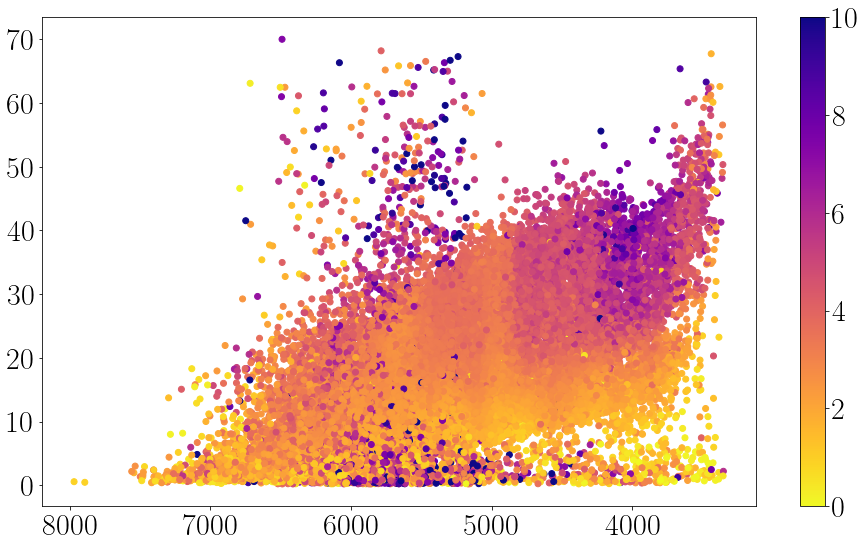

In [37]:
plt.figure(figsize=(16, 9))
plt.scatter(df.color_teffs, df.Prot, c=kin_ages, vmin=0, vmax=10, cmap="plasma_r")
plt.colorbar()
plt.gca().invert_xaxis()

(6700, 3200)

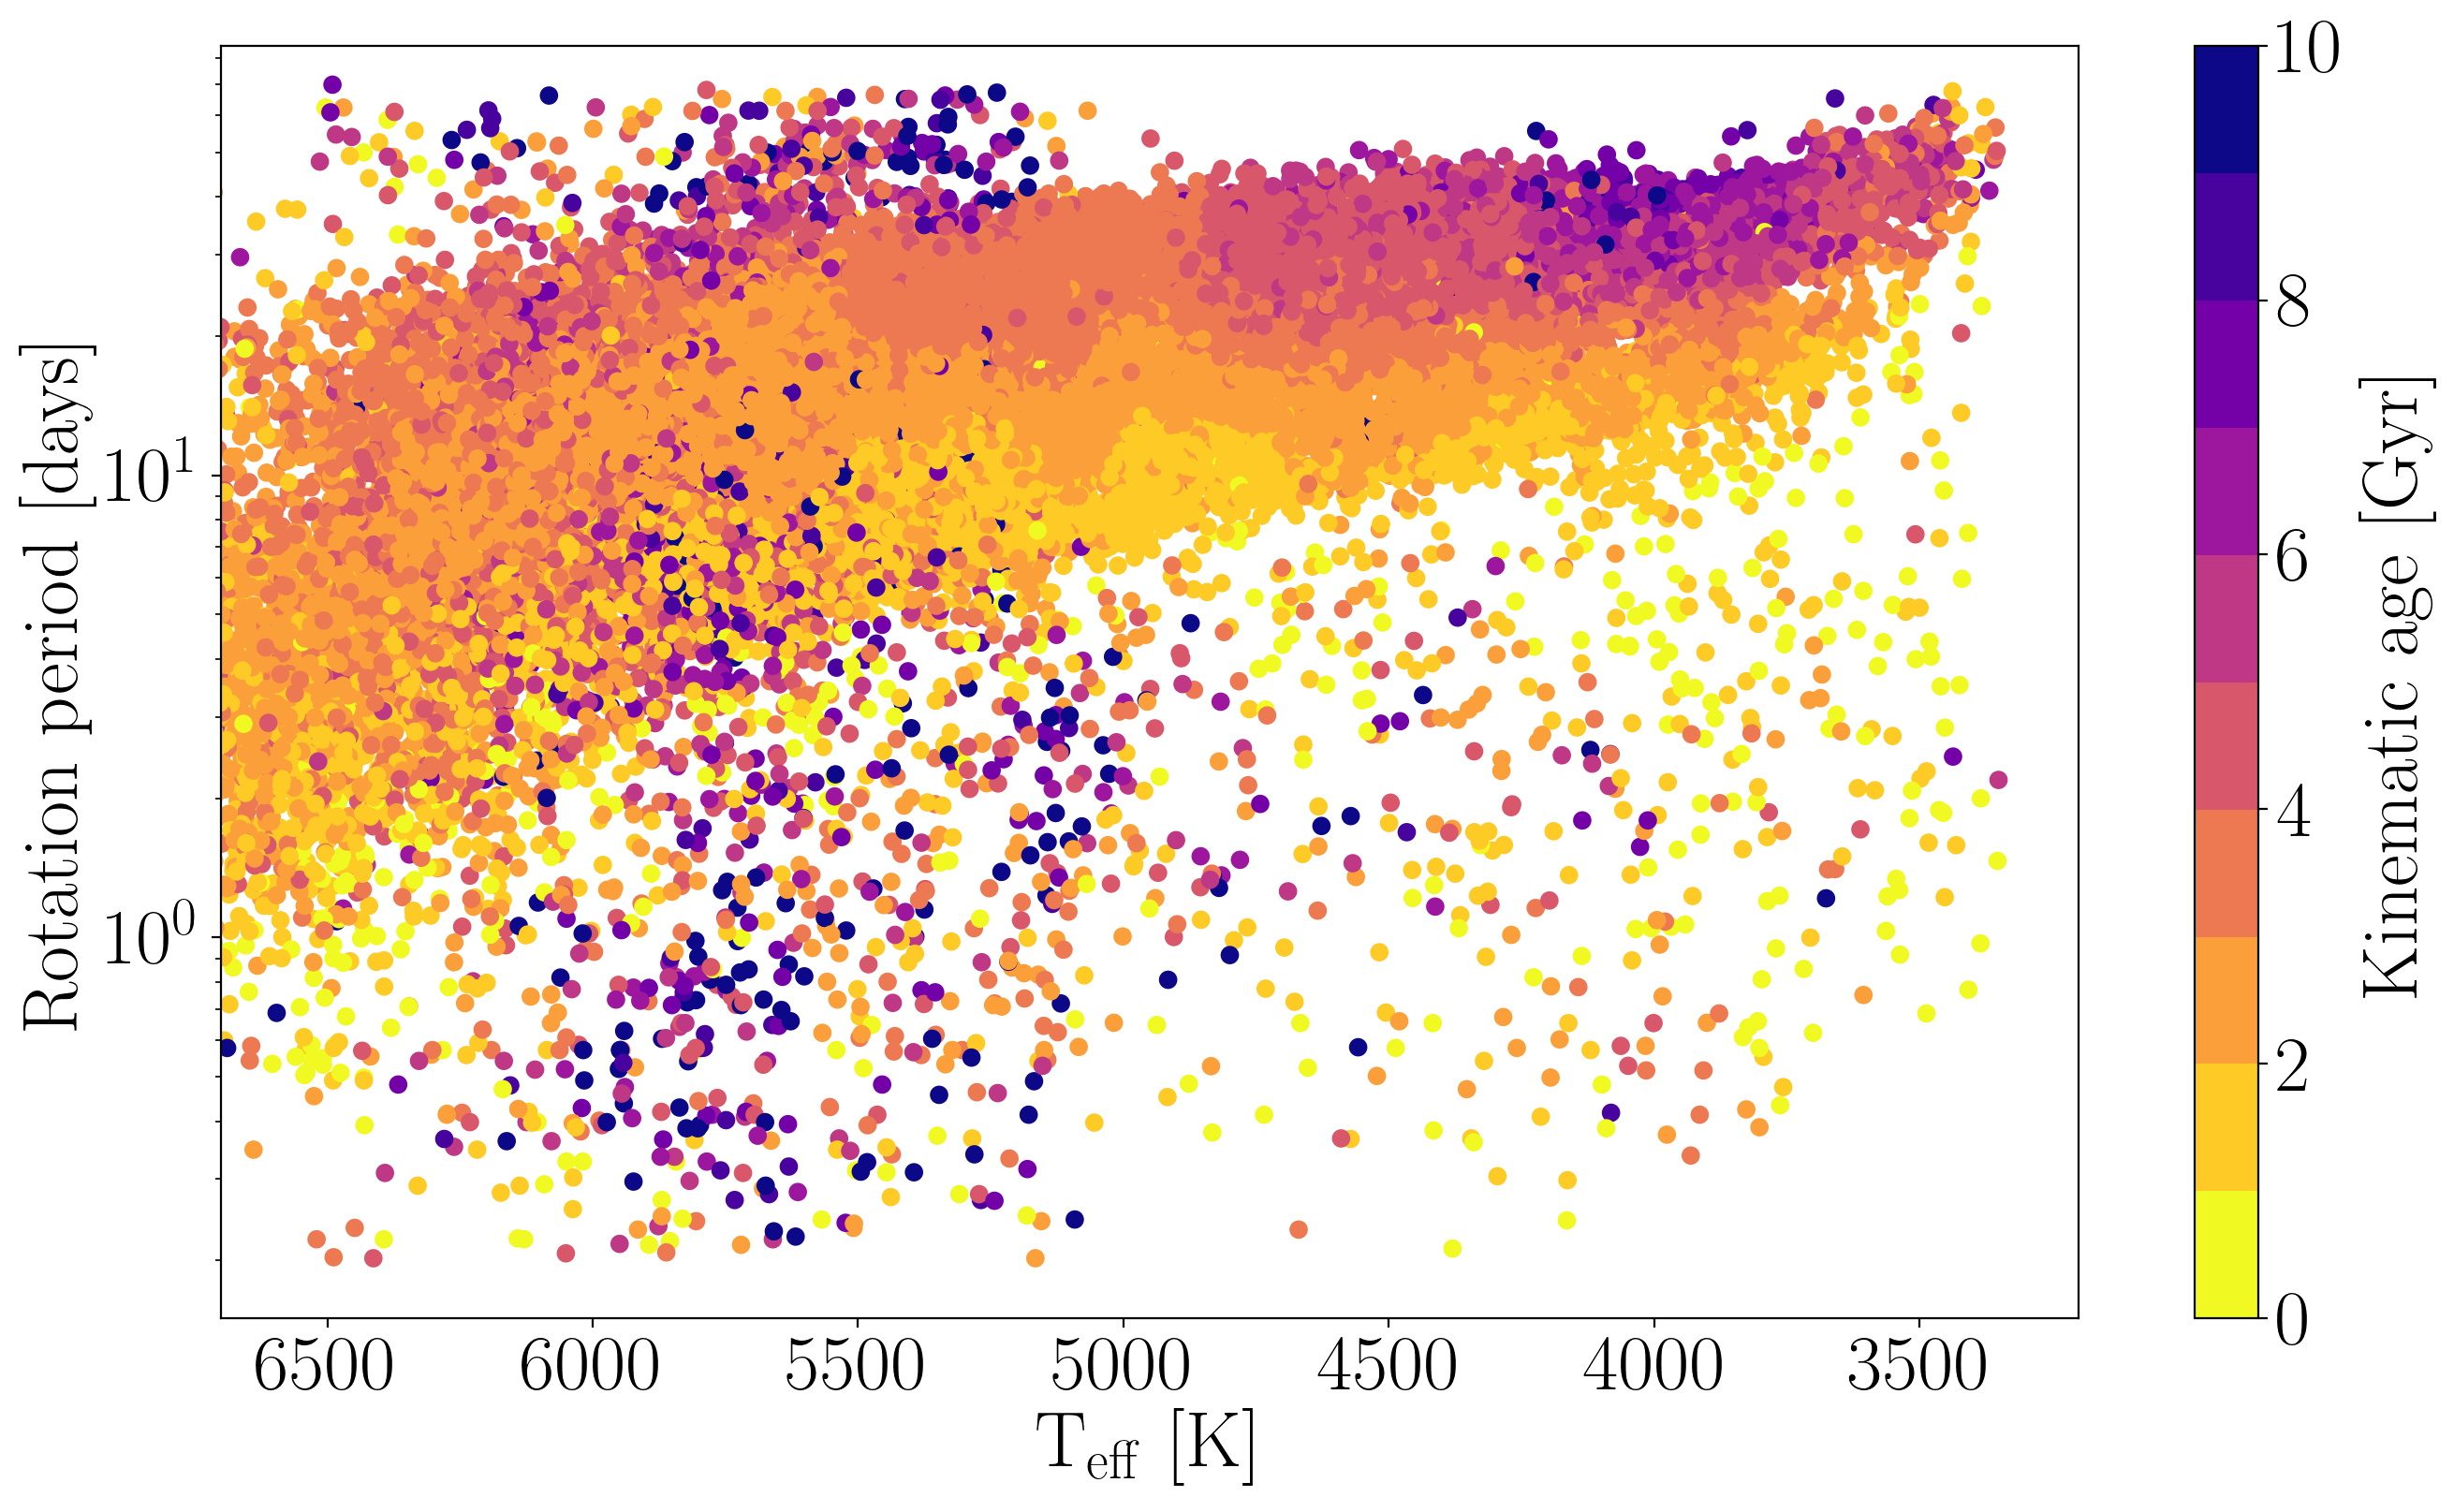

In [38]:
cmap = plt.cm.plasma_r
cmaplist = [cmap(i) for i in range(cmap.N)]
cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
bounds = np.linspace(0, 10, 11)
norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

fig = plt.figure(figsize=(16, 9), dpi=200)

plt.scatter(df.color_teffs, df.Prot, c=kin_ages, s=50, alpha=1, edgecolor="", cmap=cmap, norm=norm, zorder=1, rasterized=True)
plt.yscale("log")
plt.xlabel("$\mathrm{T_{eff}~[K]}$")
plt.ylabel("$\mathrm{Rotation~period~[days]}$")

color_bar = plt.colorbar(label="$\mathrm{Kinematic~age~[Gyr]}$")
color_bar.set_alpha(1)
color_bar.draw_all()

plt.ylim(.15, 85)
plt.xlim(6700, 3200)

(7000, 3000)

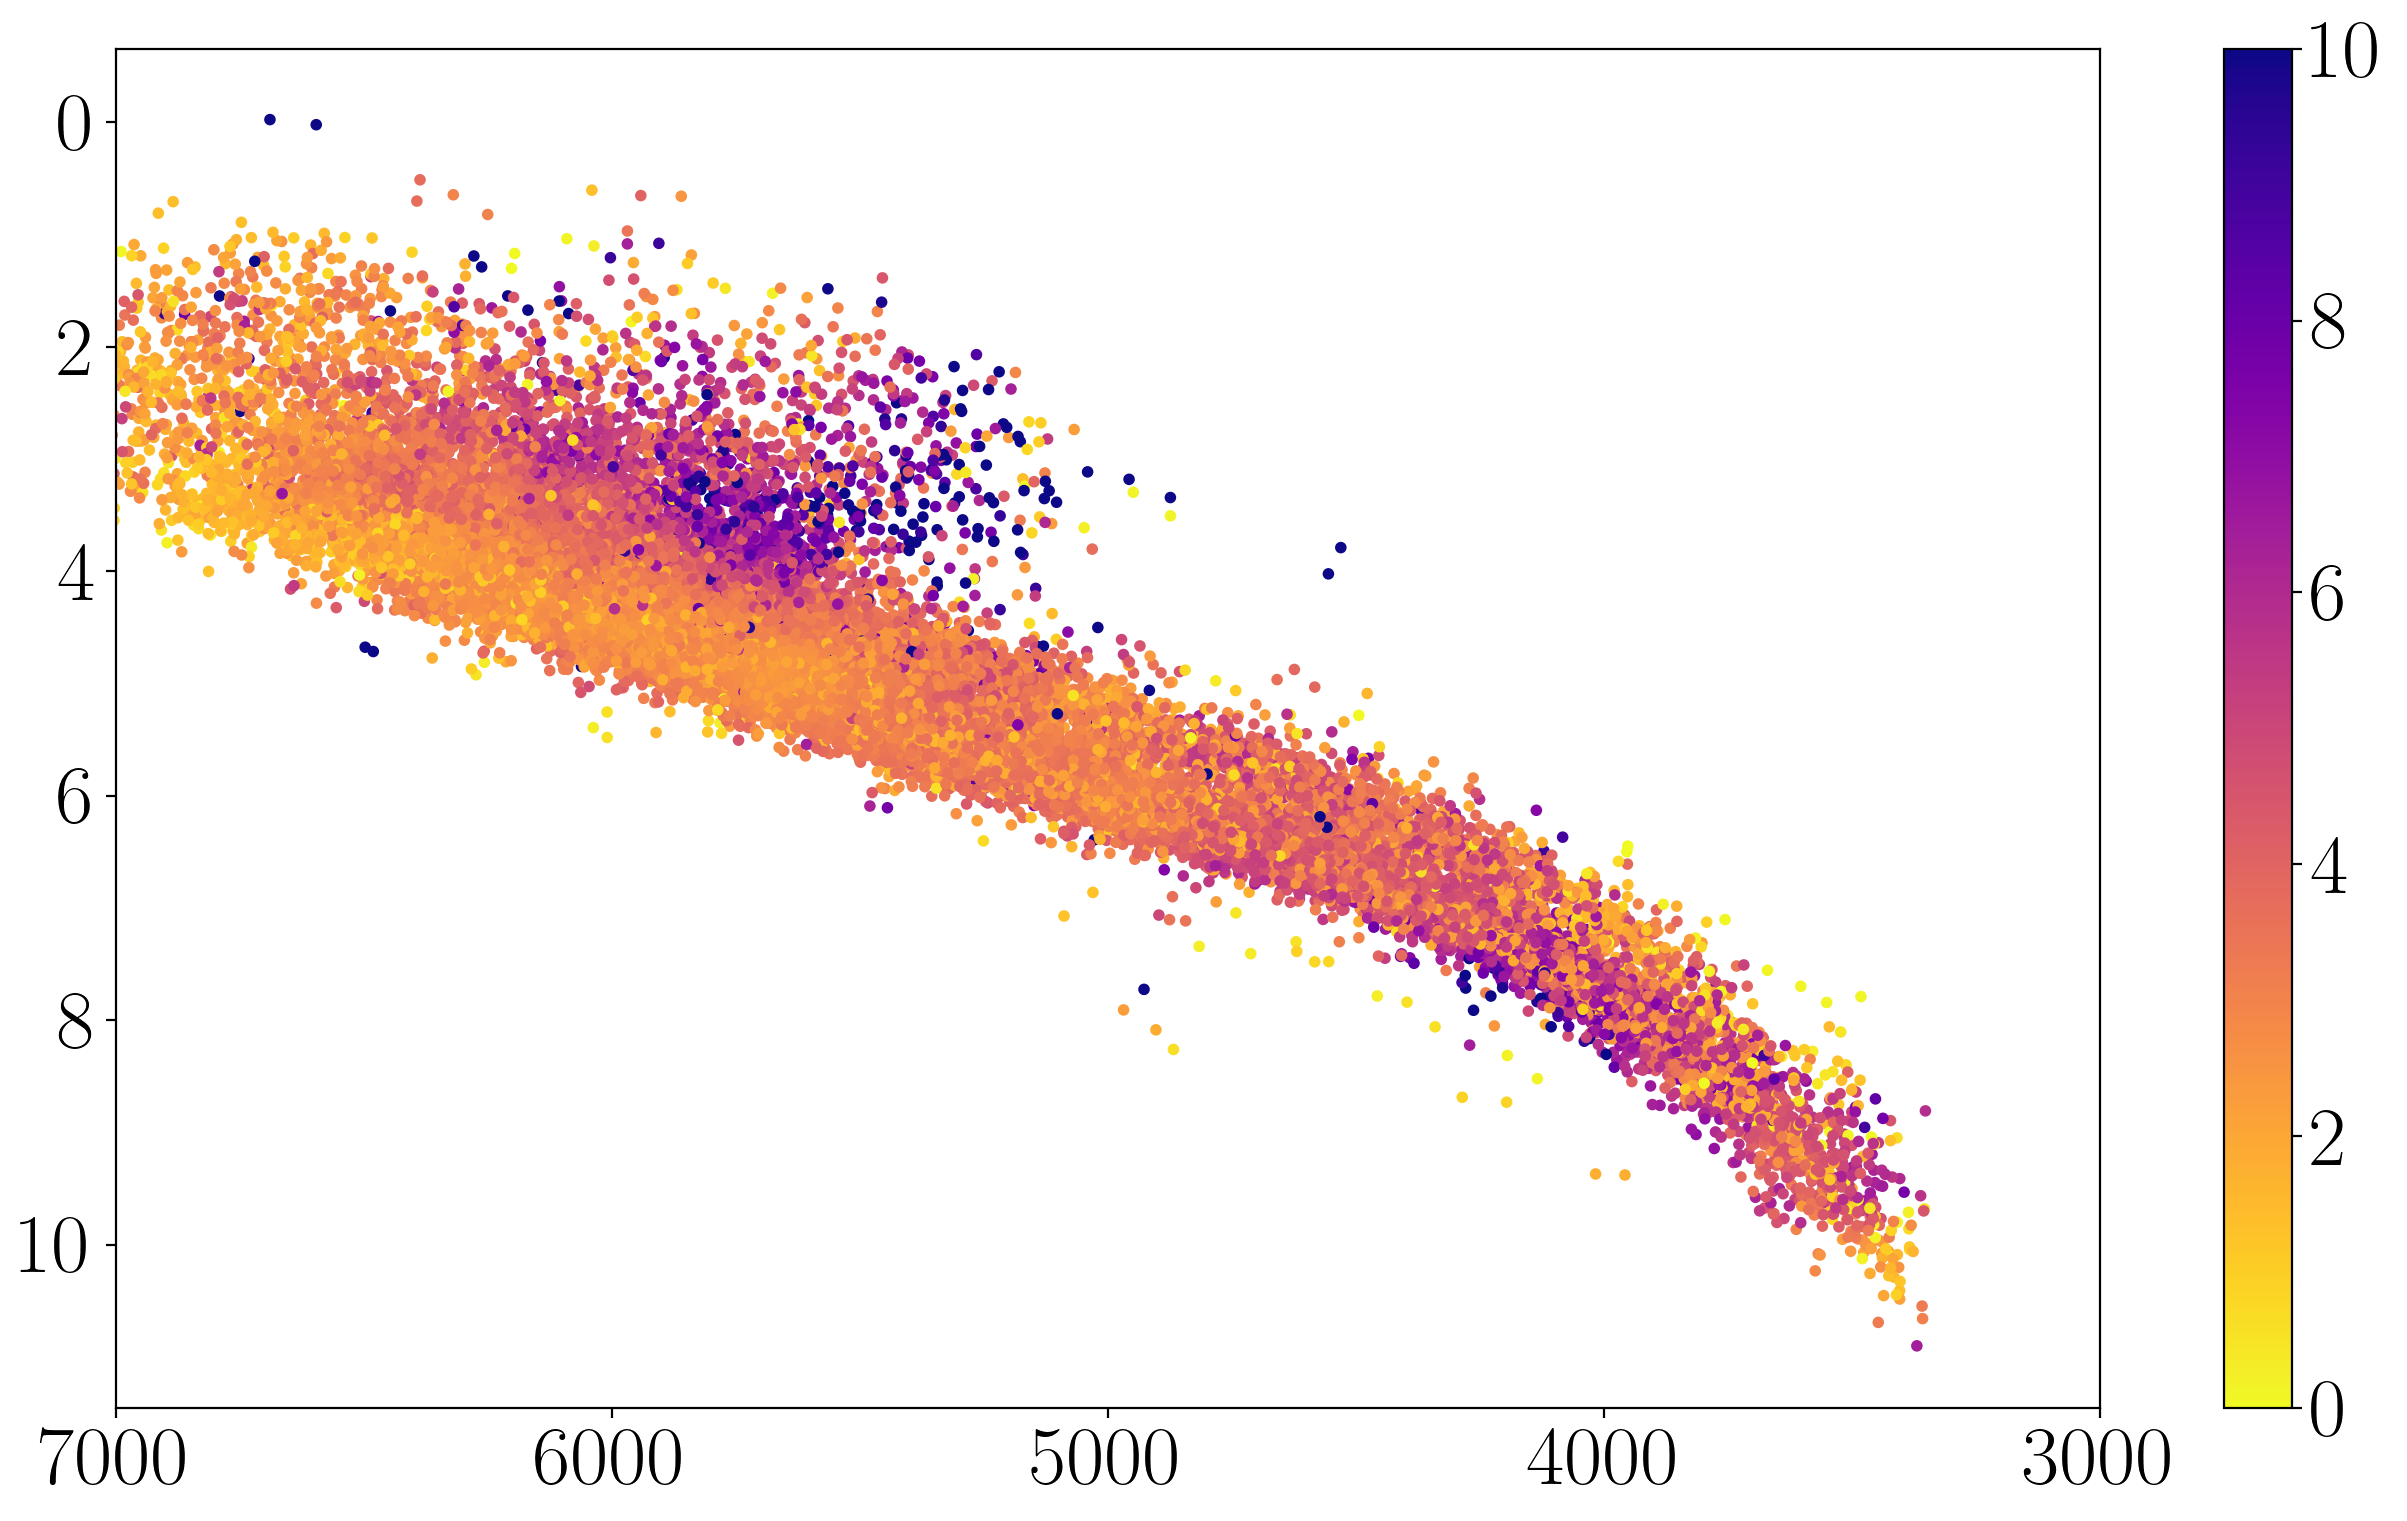

In [39]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(df.color_teffs, df.abs_G, c=kin_ages, s=10, vmin=0, vmax=10, cmap="plasma_r")
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlim(7000, 3000)
# plt.ylim(.1, 10)
# plt.yscale("log")

In [40]:
df["kinematic_age"] = kin_ages
df.to_csv("../../data/kinematic_ages.csv")

In [41]:
import pandas as pd
tb = pd.read_csv("../../data/GKSPCPapTable2_2020-04-16.txt")
tb.keys()

Index(['KIC', 'iso_mass', 'iso_mass_err1', 'iso_mass_err2', 'iso_teff',
       'iso_teff_err1', 'iso_teff_err2', 'iso_logg', 'iso_logg_err1',
       'iso_logg_err2', 'iso_feh', 'iso_feh_err1', 'iso_feh_err2', 'iso_rad',
       'iso_rad_err1', 'iso_rad_err2', 'iso_rho', 'iso_rho_err1',
       'iso_rho_err2', 'iso_lum', 'iso_lum_err1', 'iso_lum_err2', 'iso_age',
       'unReAgeFlag', 'iso_age_err1', 'iso_age_err2', 'iso_dis',
       'iso_dis_err1', 'iso_dis_err2', 'iso_avs', 'iso_gof', 'TAMS'],
      dtype='object')

In [42]:
comp = pd.merge(df, tb, left_on="kepid", right_on="KIC")
comp = comp.drop_duplicates(subset="kepid")
mean_err = .5*(comp.iso_age_err1 - comp.iso_age_err2)

(7000, 3000)

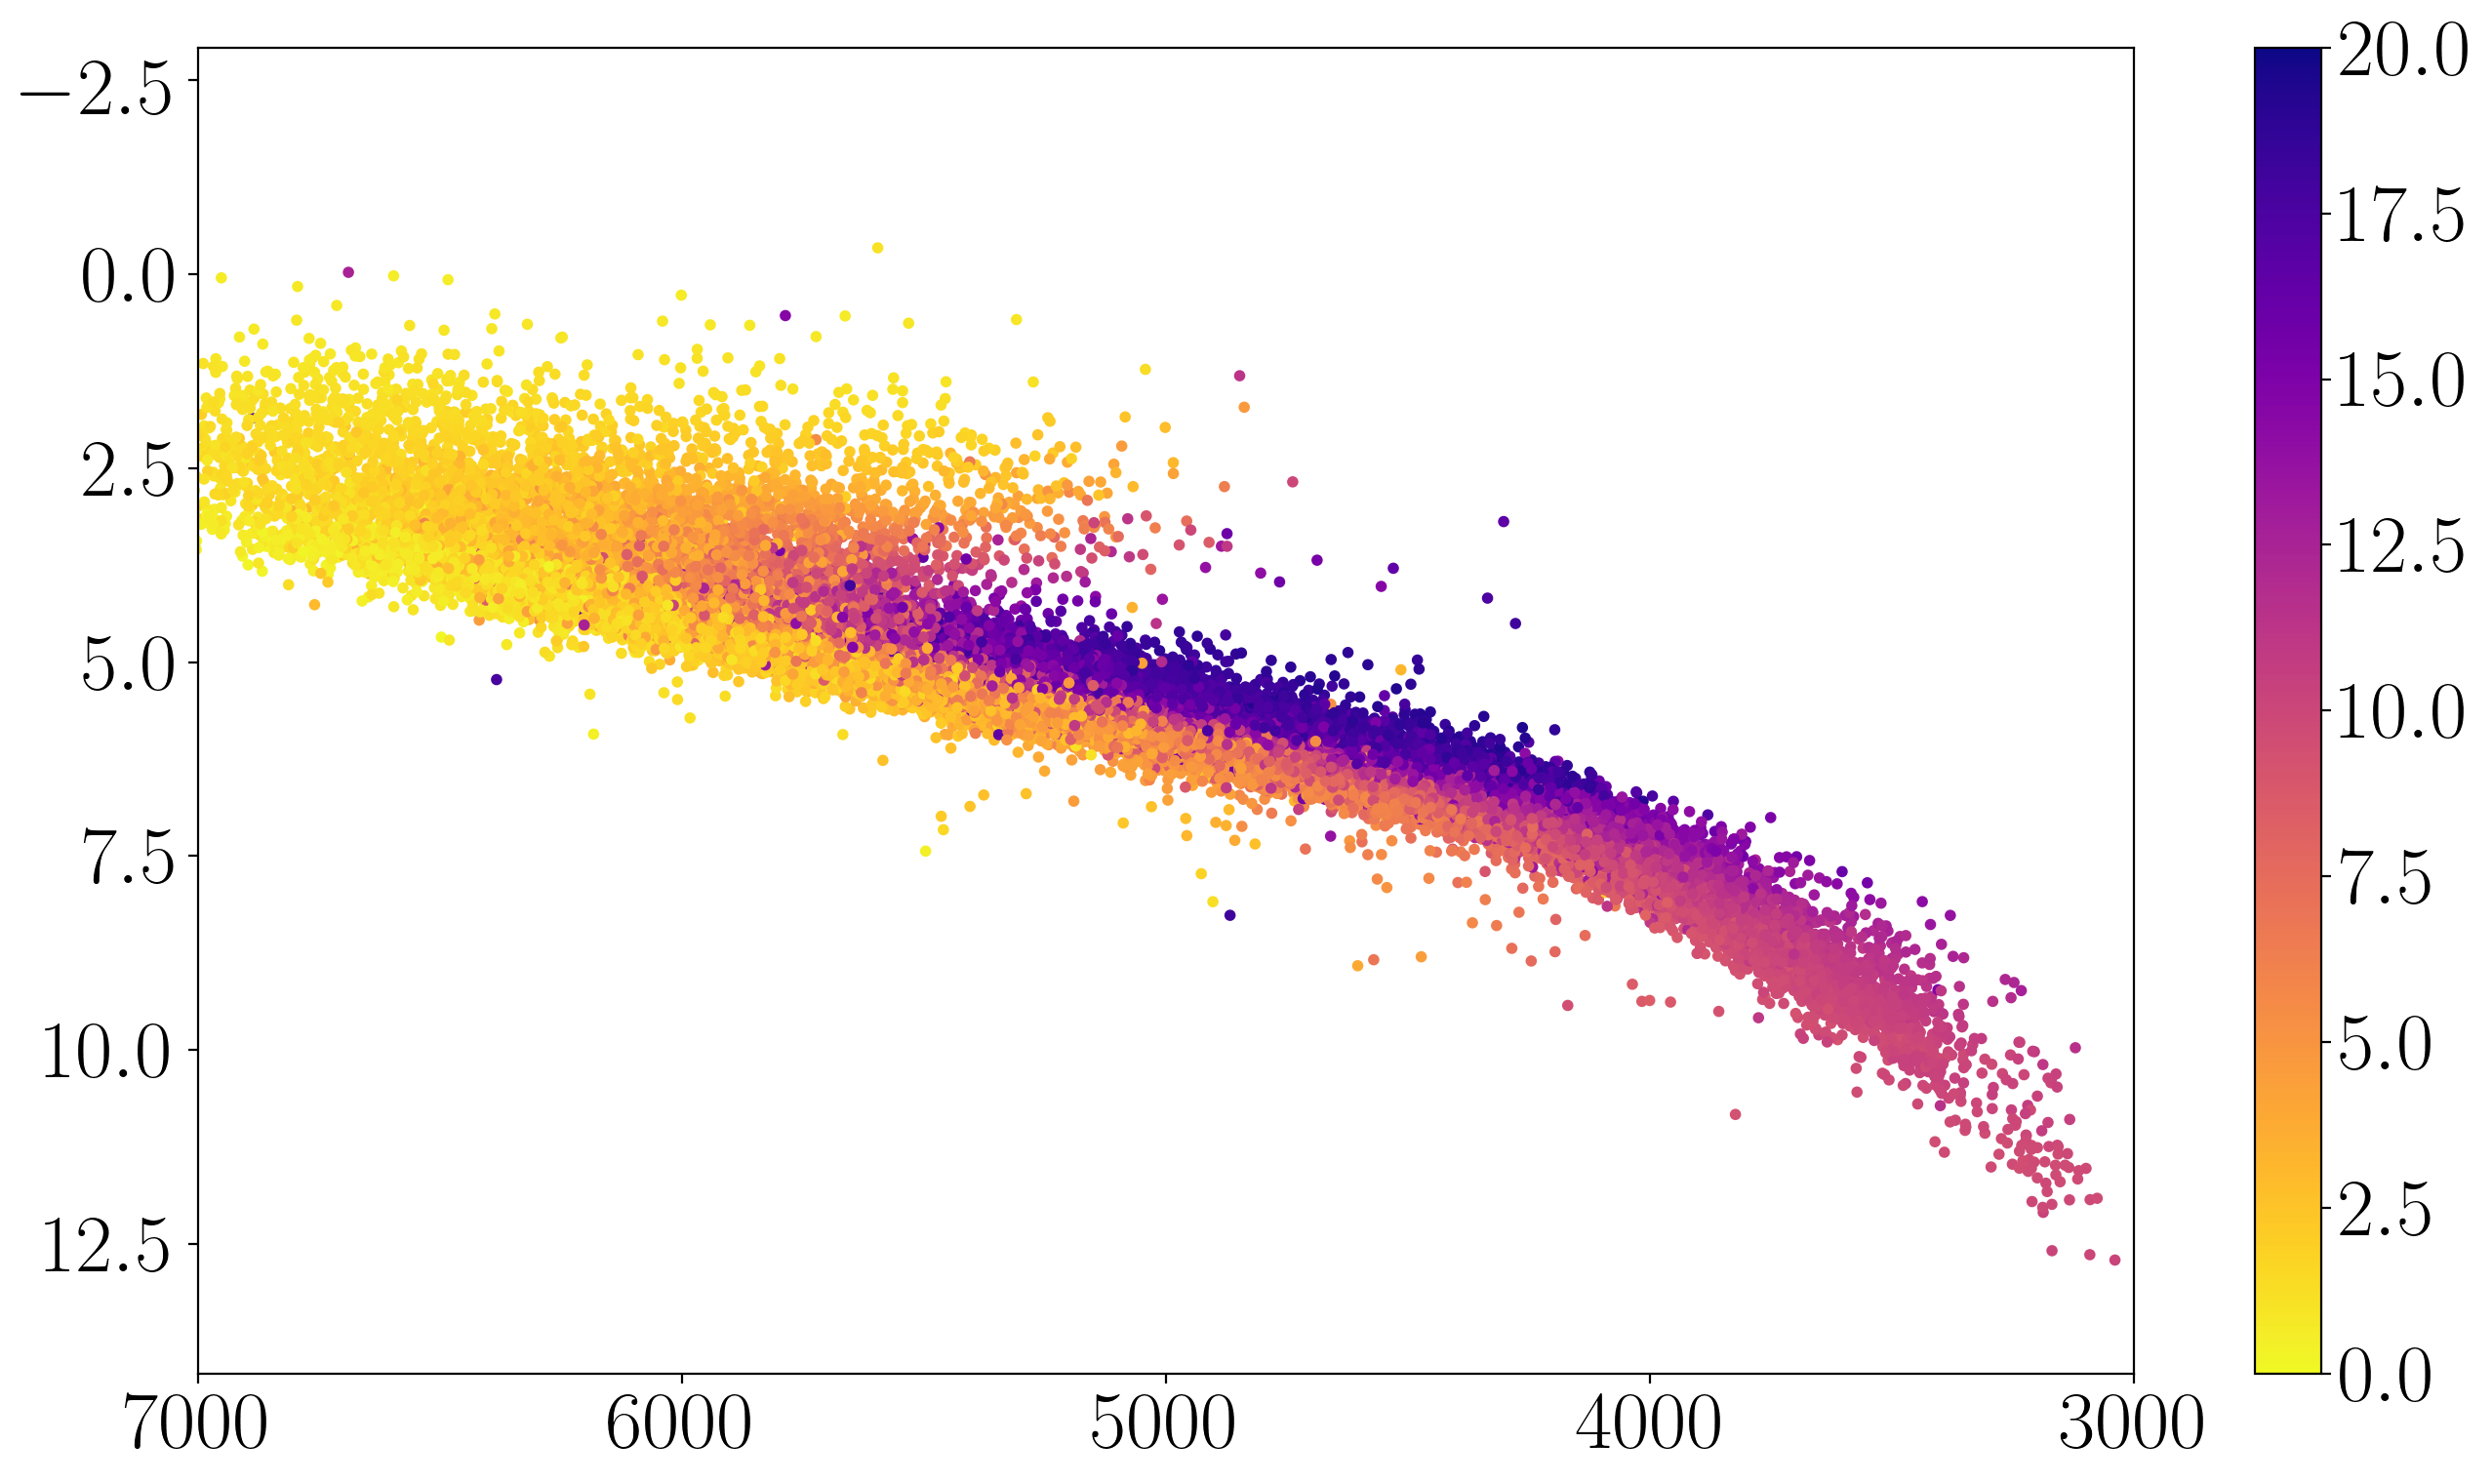

In [43]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(comp.color_teffs, comp.abs_G, c=comp.iso_age, s=10, vmin=0, vmax=20, cmap="plasma_r")
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlim(7000, 3000)
# plt.ylim(.1, 10)
# plt.yscale("log")

(0.5, 20)

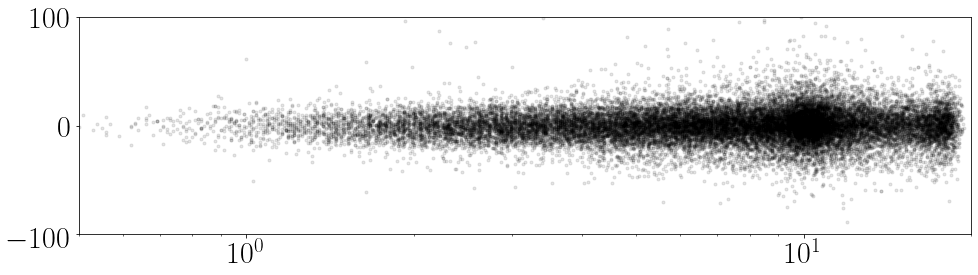

In [44]:
plt.figure(figsize=(16, 4))
plt.plot(comp.iso_age.values[comp.abs_G > 4], comp.all_vz.values[comp.abs_G > 4], "k.", alpha=.1)
plt.ylim(-100, 100)
plt.xscale("log")
plt.xlim(.5, 20)

Text(0, 0.5, 'Vz')

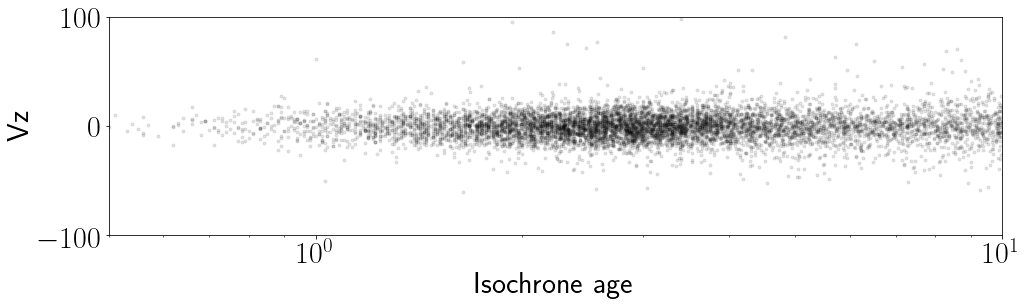

In [61]:
plt.figure(figsize=(16, 4))
plt.plot(comp.iso_age.values[(comp.abs_G > 4) & (comp.iso_age_err1 < 5)], comp.all_vz.values[(comp.abs_G > 4) & (comp.iso_age_err1 < 5)],
         "k.", alpha=.1)
plt.ylim(-100, 100)
plt.xscale("log")
plt.xlim(.5, 10)
plt.xlabel("Isochrone age")
plt.ylabel("Vz")

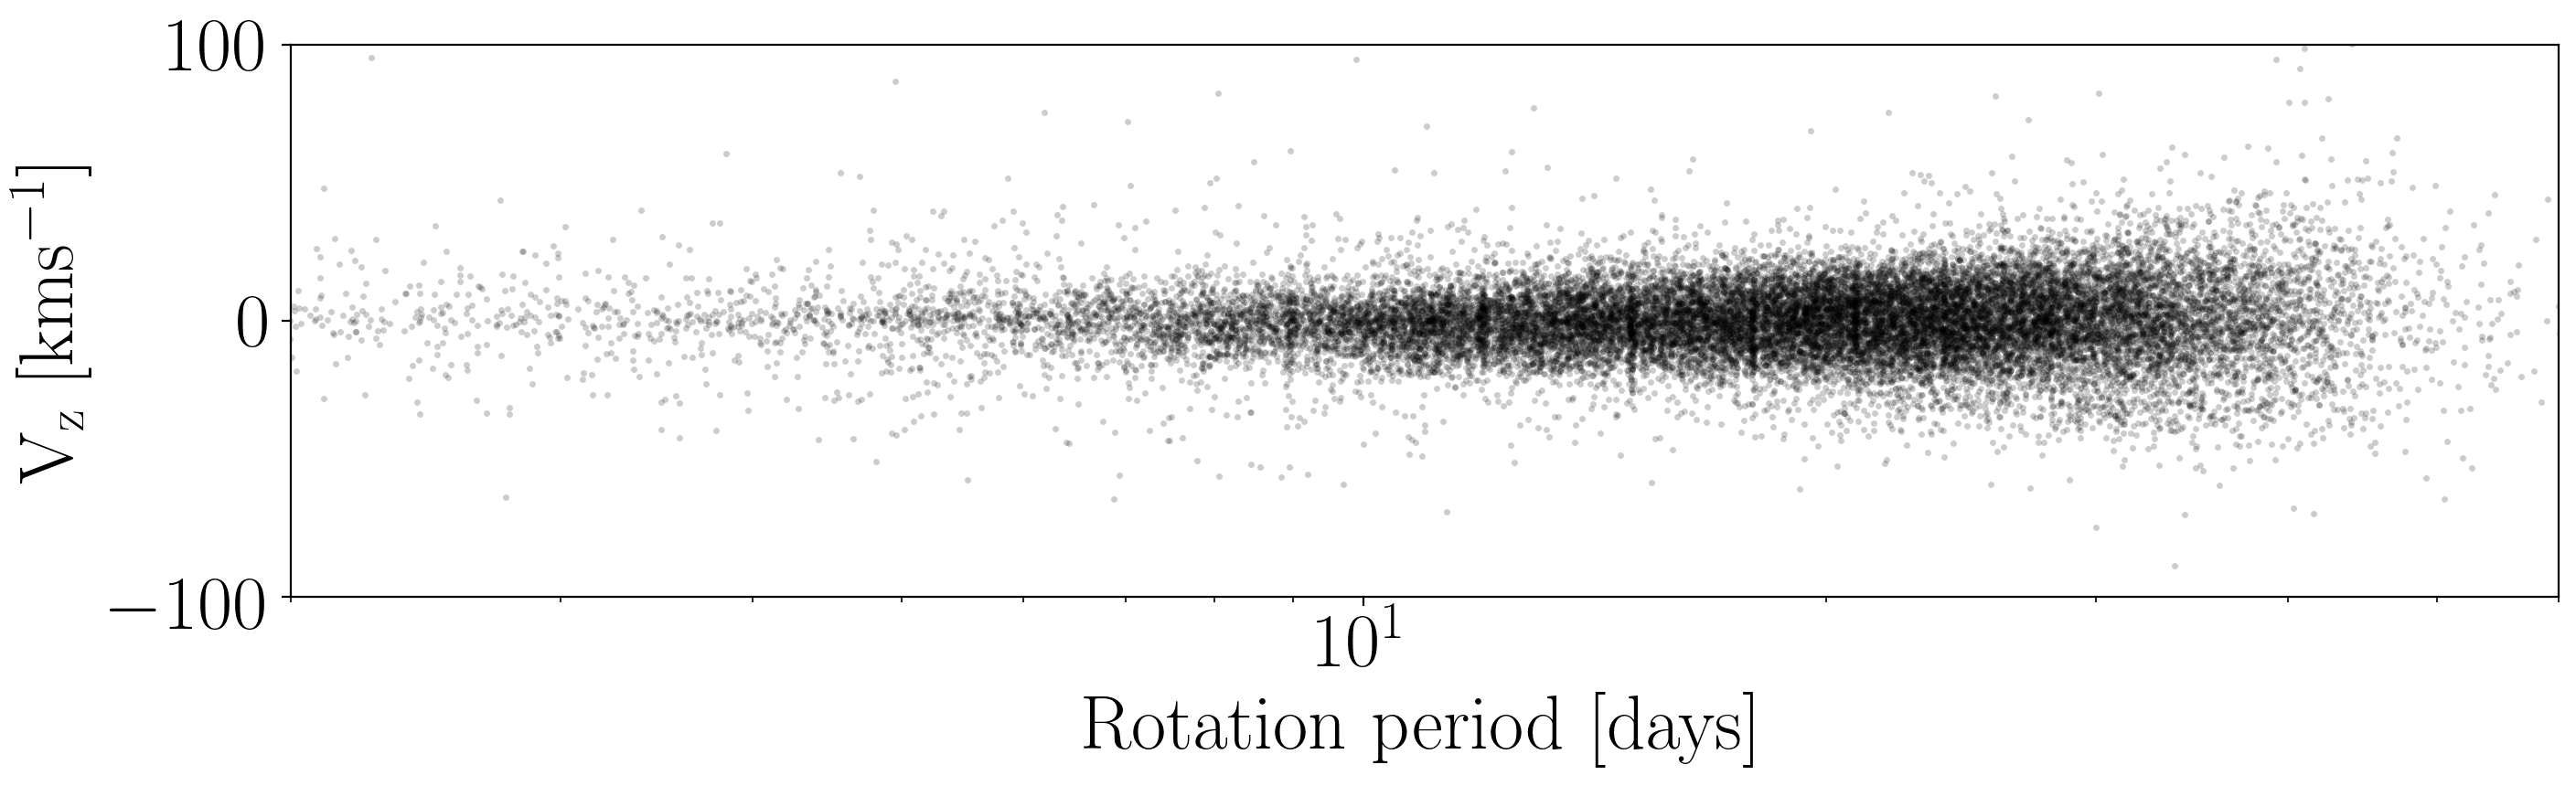

In [77]:
plt.figure(figsize=(16, 4), dpi=200)
plt.plot(comp.Prot.values[comp.abs_G > 4], comp.all_vz.values[comp.abs_G > 4], "k.", ms=5, alpha=.2, mec="none")
plt.ylim(-100, 100)
plt.xscale("log")
plt.xlim(2, 60)
plt.xlabel("$\mathrm{Rotation~period~[days]}$")
plt.ylabel("$\mathrm{V_z~[kms^{-1}]}$")
plt.savefig("vz_vs_period")
plt.savefig("vz_vs_period.pdf")

In [47]:
def calc_dispersion_CMD(teffs, mags, vs, teffrange, magrange):
    dispersions = np.zeros(len(teffs))
    for i in trange(len(teffs)):
        mask = make_mask([teffs[i], mags[i]], [teffs, mags], [teffrange, magrange])
        vbin = vs[mask]
        dispersions[i] = 1.5*aps.median_absolute_deviation(vbin, ignore_nan=True)
    return dispersions

def calc_dispersion_feh(teffs, prots, mags, fehs, vs, teffrange, protrange, magrange, fehrange):
    dispersions = np.zeros(len(teffs))
    for i in trange(len(teffs)):
        mask = make_mask([teffs[i], prots[i], mags[i], fehs[i]], [teffs, prots, mags, fehs], [teffrange, protrange, magrange, fehrange])
        vbin = vs[mask]
        dispersions[i] = 1.5*aps.median_absolute_deviation(vbin, ignore_nan=True)
    return dispersions

In [48]:
dx, dy = 100, .4

In [49]:
dispersions_cmd = calc_dispersion_CMD(comp.color_teffs.values, comp.abs_G.values, comp.all_vz.values, dx, dy)

100%|██████████| 34237/34237 [00:06<00:00, 5453.42it/s]


In [50]:
kin_ages_cmd = av.v_to_age(dispersions_cmd, p_mr)

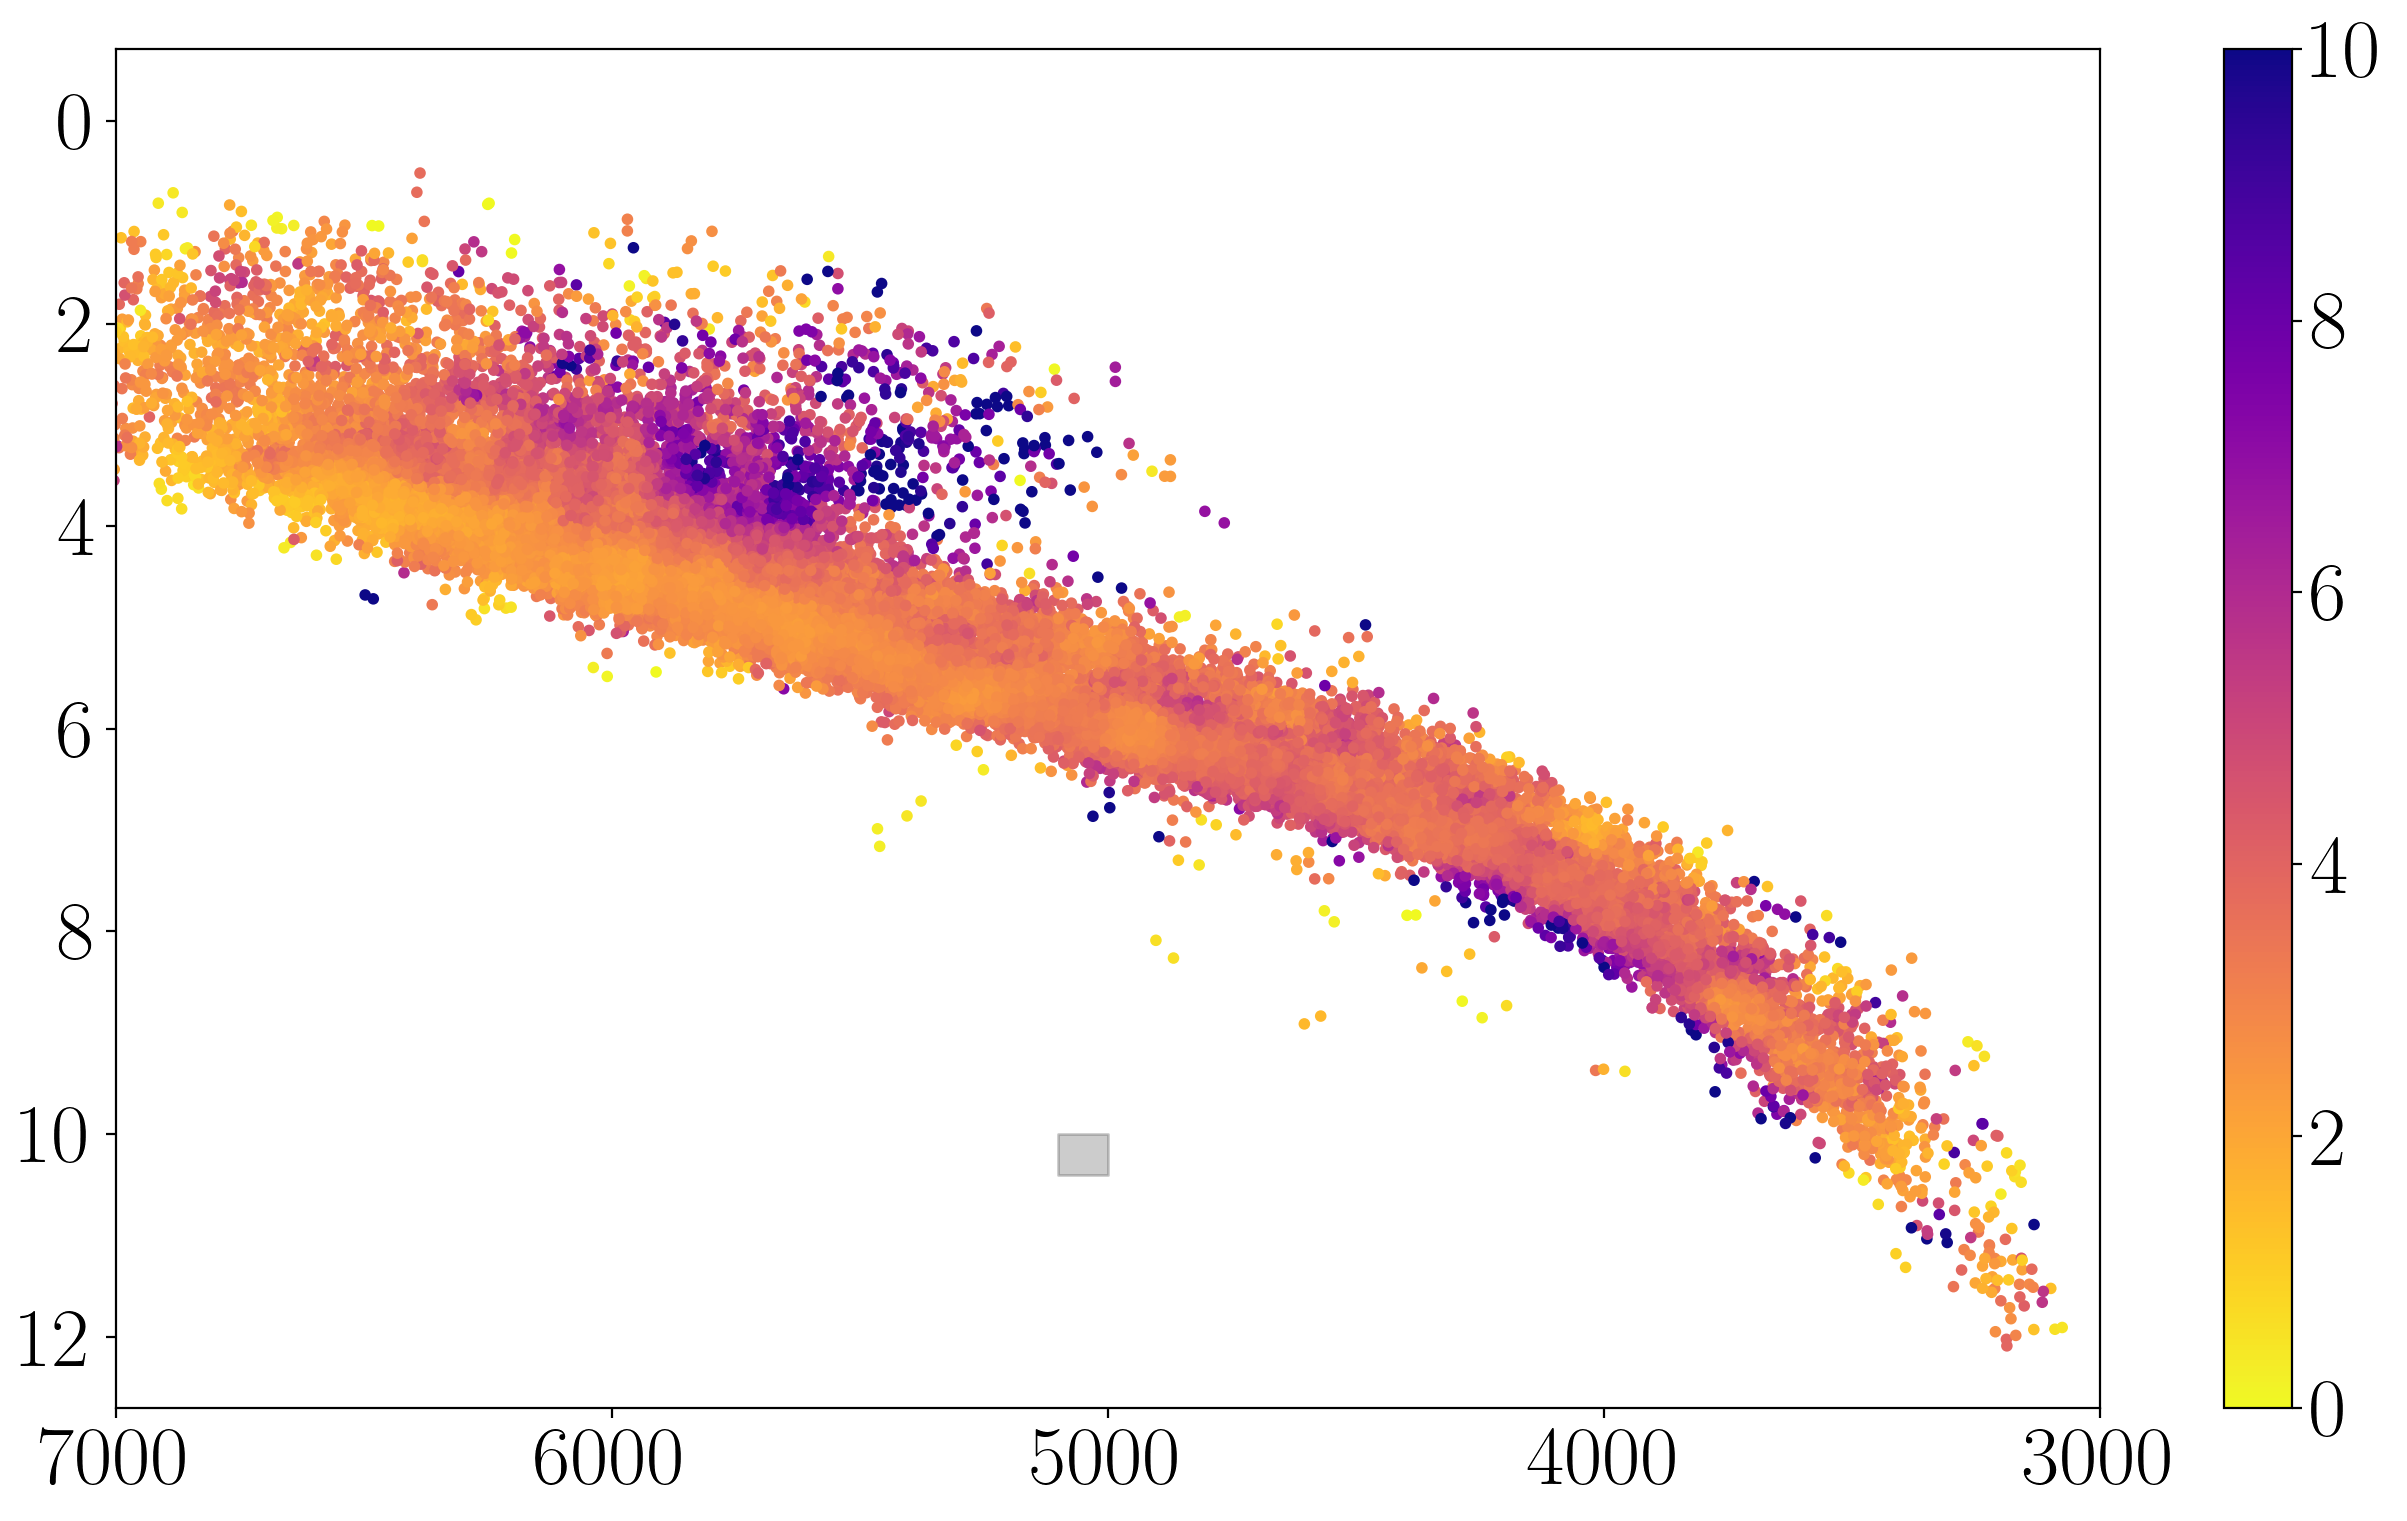

In [51]:
plt.figure(figsize=(16, 9), dpi=200)
plt.scatter(comp.color_teffs, comp.abs_G, c=kin_ages_cmd, s=10, vmin=0, vmax=10, cmap="plasma_r")
plt.colorbar()
plt.gca().invert_xaxis()
plt.gca().invert_yaxis()
plt.xlim(7000, 3000);

xspot, yspot = 5000, 10
xs = np.linspace(xspot, xspot+dx, 100)
plt.fill_between(xs, yspot, yspot + dy, color="k", alpha=.2)

In [52]:
# dz, da = .4, .1
# dispersions_feh = calc_dispersion_feh(comp.color_teffs.values, np.log10(comp.Prot.values), comp.abs_G.values, comp.iso_feh,
#                                       comp.all_vz.values, dx, dy, dz, da)

In [53]:
# kin_ages_feh = av.v_to_age(dispersions_feh, p_mr)

In [54]:
# plt.figure(figsize=(16, 9), dpi=200)
# plt.scatter(comp.color_teffs, comp.abs_G, c=kin_ages_feh, s=10, vmin=0, vmax=10, cmap="plasma_r")
# plt.colorbar()
# plt.gca().invert_xaxis()
# plt.gca().invert_yaxis()
# plt.xlim(7000, 3000);

# xspot, yspot = 5000, 10
# xs = np.linspace(xspot, xspot+dx, 100)
# plt.fill_between(xs, yspot, yspot + dy, color="k", alpha=.2)

In [55]:
# cmap = plt.cm.plasma_r
# cmaplist = [cmap(i) for i in range(cmap.N)]
# cmap = matplotlib.colors.LinearSegmentedColormap.from_list('Custom cmap', cmaplist, cmap.N)
# bounds = np.linspace(0, 10, 11)
# norm = matplotlib.colors.BoundaryNorm(bounds, cmap.N)

# fig = plt.figure(figsize=(16, 9), dpi=200)

# plt.scatter(comp.color_teffs, comp.Prot, c=kin_ages_feh, s=50, alpha=1, edgecolor="", cmap=cmap, norm=norm, zorder=1, rasterized=True)
# plt.yscale("log")
# plt.xlabel("$\mathrm{T_{eff}~[K]}$")
# plt.ylabel("$\mathrm{Rotation~period~[days]}$")

# color_bar = plt.colorbar(label="$\mathrm{Kinematic~age~[Gyr]}$")
# color_bar.set_alpha(1)
# color_bar.draw_all()

# plt.ylim(.15, 85)
# plt.xlim(6700, 3200)

In [56]:
# plt.figure(figsize=(16, 9))
# # plt.errorbar(comp.iso_age.values, comp.kinematic_age, xerr=[-comp.iso_age_err2.values, comp.iso_age_err1.values],
# #              fmt=".k", alpha=.1, zorder=0)
# plt.plot(comp.iso_age.values[precise_not_bin], comp.kinematic_age[precise_not_bin], ".k", alpha=.10)
# xs = np.linspace(0, 12, 100)
# plt.xlim(0, 15)
# plt.plot(xs, xs)
# plt.ylabel("$\mathrm{Kinematic~age~[Gyr]}$")
# plt.xlabel("$\mathrm{Isochronal~age~[Gyr]}$")
# plt.ylim(0, 15)

In [57]:
def calc_dispersion(teffs, prots, mags, ages, age_err, vs, teffrange, protrange, magrange):
    dispersions, av_age = [np.zeros(len(teffs)) for i in range(2)]
    for i in trange(len(teffs)):
        mask = make_mask([teffs[i], prots[i], mags[i]], [teffs, prots, mags], [teffrange, protrange, magrange])
        vbin = vs[mask]
        av_age[i] = np.mean(ages[mask])
        dispersions[i] = 1.5*aps.median_absolute_deviation(vbin, ignore_nan=True)
    return dispersions, av_age

In [62]:
dt, dp, dm = 100, .3, .4
m = np.isfinite(comp.iso_age.values) & np.isfinite(comp.iso_age_err1.values)
import time
start = time.time()
disps, av_ages = calc_dispersion(comp.color_teffs.values[m], np.log10(comp.Prot.values[m]),
                                 comp.abs_G.values[m], comp.iso_age.values[m], comp.iso_age_err1.values[m]/sum(comp.iso_age_err1.values[m]),
                                 comp.all_vz.values[m], dt, dp, dm)
stop = time.time()
print(stop - start)
av_kin_ages = av.v_to_age(disps, p_mr)

 78%|███████▊  | 26728/34237 [00:06<00:01, 4073.54it/s]/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/numpy/core/fromnumeric.py:3335: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/Users/rangus/Applications/anaconda3/lib/python3.7/site-packages/numpy/lib/nanfunctions.py:1113: RuntimeWarning: Mean of empty slice
  return np.nanmean(a, axis, out=out, keepdims=keepdims)
100%|██████████| 34237/34237 [00:08<00:00, 4217.17it/s]

8.127733945846558


In [59]:
savedf = comp.iloc[m]
savedf["kinematic_age_cmd"] = av_kin_ages
savedf.to_csv("../../data/kinematic_ages_cmd.csv")

Text(0, 0.5, 'Isochronal age')

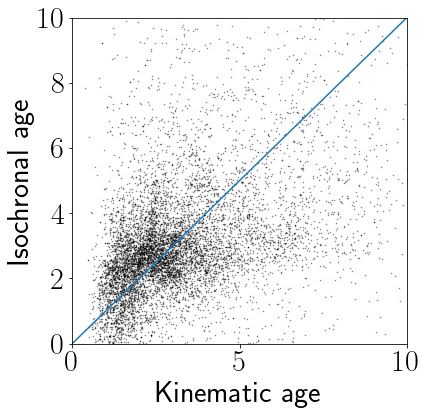

In [28]:
mask = np.isfinite(av_kin_ages) & np.isfinite(av_ages) & (comp.iso_age.values < 10) & (comp.iso_age_err1.values < 3)
plt.figure(figsize=(6, 6))
plt.plot(av_ages[mask], av_kin_ages[mask], "k.", ms=1, alpha=.5)
xs = np.linspace(0, 15)
plt.plot(xs, xs)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("Kinematic age")
plt.ylabel("Isochronal age")

In [29]:
print(sum((av_ages[mask] - av_kin_ages[mask])**2/comp.iso_age_err1[m][mask]**2))

422873.6740107765


Text(0, 0.5, 'Isochronal age')

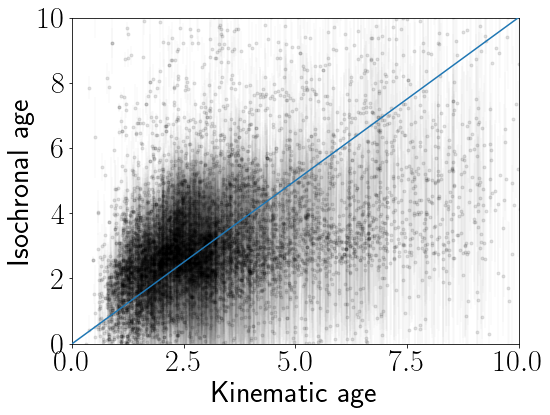

In [30]:
plt.figure(figsize=(8, 6))
plt.errorbar(av_ages[mask], av_kin_ages[mask], yerr=comp.iso_age_err1[m][mask], ms=.1, fmt="k.", alpha=.02)
plt.plot(av_ages[mask], av_kin_ages[mask], "k.", alpha=.1)
# plt.scatter(av_ages[mask], av_kin_ages[mask], c=comp.iso_teff.values[m][mask], zorder=10)
# plt.colorbar()

xs = np.linspace(0, 15)
plt.plot(xs, xs, zorder=10)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("Kinematic age")
plt.ylabel("Isochronal age")

In [79]:
xd = pd.DataFrame(dict({"iso_age": av_ages[mask],
                        "kin_age": av_kin_ages[mask],
                        "iso_age_err": comp.iso_age_err1[m][mask]
                       }))
xd.to_csv("xd.csv")

In [319]:
within_one_sigma = abs(av_ages[mask] - av_kin_ages[mask]) < comp.iso_age_err1[m][mask]
within_two_sigma = abs(av_ages[mask] - av_kin_ages[mask]) < 2*comp.iso_age_err1[m][mask]

print(float(sum(within_one_sigma))/float(len(av_kin_ages[mask])))
print(float(sum(within_two_sigma))/float(len(av_kin_ages[mask])))

0.5637039540385266
0.7708685366677932


(-5, 5)

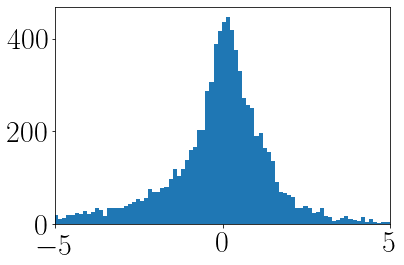

In [327]:
plt.hist((av_ages[mask] - av_kin_ages[mask])/comp.iso_age_err1[m][mask], 2000);
plt.xlim(-5, 5)

(-10, 10)

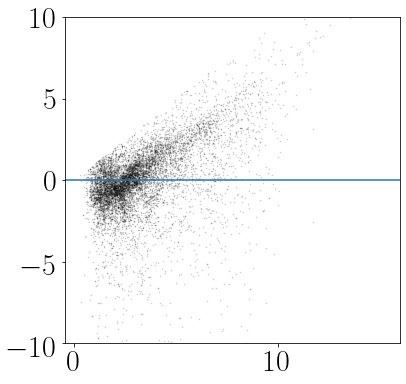

In [311]:
plt.figure(figsize=(6, 6))
plt.plot(av_ages[mask], av_ages[mask] - av_kin_ages[mask], "k.", alpha=.2, ms=1)#, yerr=comp.iso_age_err1[m][mask], fmt="k.", alpha=.05)
xs = np.linspace(0, 15)
plt.axhline(0)
plt.ylim(-10, 10)

Text(0, 0.5, 'Isochronal age')

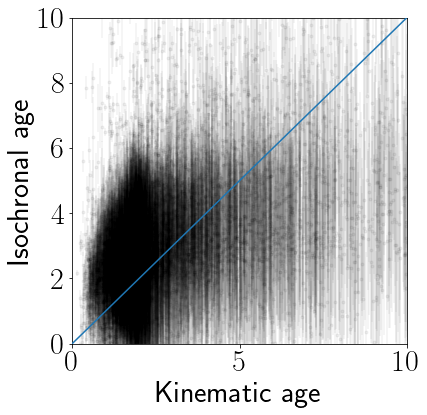

In [305]:
plt.figure(figsize=(6, 6))
plt.errorbar(comp.iso_age.values[m][mask], av_kin_ages[mask], yerr=comp.iso_age_err1[m][mask], fmt="k.", alpha=.05)
xs = np.linspace(0, 15)
plt.plot(xs, xs, zorder=10)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("Kinematic age")
plt.ylabel("Isochronal age")

Text(0, 0.5, 'Isochronal age')

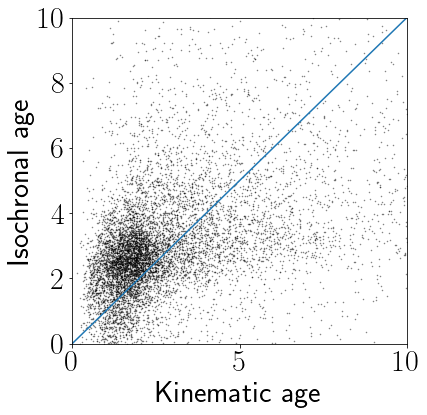

In [306]:
mask = np.isfinite(av_kin_ages) & np.isfinite(av_ages) & (comp.iso_age.values < 10) & (comp.iso_age_err1.values < 3)
plt.figure(figsize=(6, 6))
plt.plot(comp.iso_age.values[m][mask], av_kin_ages[mask], "k.", ms=1, alpha=.5)
xs = np.linspace(0, 15)
plt.plot(xs, xs)
plt.xlim(0, 10)
plt.ylim(0, 10)
plt.xlabel("Kinematic age")
plt.ylabel("Isochronal age")